In [1]:
import datetime as dt

import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle


from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## select the crop

In [2]:
crop = 'Tomato'

In [3]:
files = glob.glob('../../data/raw/*/report.csv')

In [4]:
tomato_fids = "68519 68513 68400 68514 68518 68517 68372 68398 68377 68403 68406 68526 68405 68399 68515 68528 68831".split(' ') 

In [5]:
chilli_fids = "68376 68752 68765 68719 68727 68764 68373 68731".split(' ')

In [6]:
client = pd.read_csv('../../data/info/all_info.csv')

In [7]:
def error(df, x, y):
    mae = mean_absolute_error(df[x], df[y])
    mse = mean_squared_error(df[x], df[y])
    var = df[y].var()
    corr = df[x].corr(df[y]) 
    bias = (df[y]-df[x]).sum()/(df[x].sum()) *100
    r2 = r2_score(df[x], df[y])
    try:
        rpd = (statistics.stdev(df[x]))/(np.sqrt(mse))
    except:
        rpd = None
    
    return mae, mse, var, corr, bias, r2, rpd

In [8]:
loss_rain = []
fids_list = []

rec = []
for fil in files:
    
    fid = fil.split('/')[-2]
    
    if crop == 'Tomato':
        l1 = tomato_fids

    else:
        l1 = chilli_fids
    
    if fid in l1:

        fids_list.append(fid)
    
        data = pd.read_csv(fil)
        
        data['date'] = data['Date time (time zone: Asia/Kolkata)'].apply(
           lambda x: pd.to_datetime(x).date())
        
        
        
        data = data.loc[data['Rain fall (mm)']!='-']
        
        data = data.loc[data['Wind Speed (kmh)']!='-']
        data = data.loc[data['Humidity (%)'] != '-']
        
        data = data.loc[data['Temperature (°C)'] != '-']
        
        data = data.loc[data['Soil temperature (°C)'] != '-']
        
        data['Rain fall (mm)'] = data['Rain fall (mm)'].astype(float)
        
        data['Wind Speed (kmh)'] = data['Wind Speed (kmh)'].astype(float)
        
        data['Humidity (%)'] = data['Humidity (%)'].astype(float)
     
        data['Soil temperature (°C)'] = data['Soil temperature (°C)'].astype(float)
        
        data['Temperature (°C)'] = data['Temperature (°C)'].astype(float)
        
        
        
        sow, actul_yield = client.loc[client.fid == int(fid), ['sowingdt','Actual Yield']].values[0]
        
        
        data2 = data.groupby(['date']).sum().reset_index()[['date','Rain fall (mm)', 'Wind Speed (kmh)']]
        
        eva = pd.read_csv(f'../../data/raw/{fid}/vpd.csv')
        
        eva['date'] = eva['Date time (time zone: Asia/Kolkata)'].apply(
           lambda x: pd.to_datetime(x).date())


        eva['days'] = eva['date'].apply(lambda x : (x - dt.datetime.strptime(sow, '%Y-%m-%d').date()).days)
    
    
        gdd = pd.read_csv(f'../../data/raw/{fids_list[-1]}/gdd.csv')

        gdd['date'] = gdd['Date time (time zone: Asia/Kolkata)'].apply(
                   lambda x: pd.to_datetime(x).date())


        gdd['days'] = gdd['date'].apply(lambda x : (x - dt.datetime.strptime(sow, '%Y-%m-%d').date()).days)
        
        
        evp = pd.read_csv(f'../../data/raw/{fids_list[-1]}/evapotranspiration.csv')

        evp['date'] = evp['Date time (time zone: Asia/Kolkata)'].apply(
                   lambda x: pd.to_datetime(x).date())


        evp['days'] = evp['date'].apply(lambda x : (x - dt.datetime.strptime(sow, '%Y-%m-%d').date()).days)

        
        data2['days'] = data2['date'].apply(lambda x : (x - dt.datetime.strptime(sow, '%Y-%m-%d').date()).days)
        
        data3 = data.groupby(['date']).mean().reset_index()[['Temperature (°C)', 'Humidity (%)', 'Soil temperature (°C)']]
        
        ind = data2[['Rain fall (mm)']].idxmax()[0]
        

        
        val = data2.iloc[ind][1:].values
        
        day = val[2]
        
        if val[2] == 94:
            val[2] = 125
            
            
        
        d = {
            
            'fid' :fid,
            'Rain fall (mm)':val[0],
            'Wind Speed (kmh)':data.loc[data['date']== data2.iloc[ind]['date']]['Wind Speed (kmh)'].max(),
            'days':val[2],
            'Temp_min':data3['Temperature (°C)'].min(),
            'Temp_max':data3['Temperature (°C)'].max(),
            'Temp_mean':data3['Temperature (°C)'].mean(),
            'Humd_min':data3['Humidity (%)'].min(),
            'Humd_max':data3['Humidity (%)'].max(),
            'Humd_mean':data3['Humidity (%)'].mean(),
            'actual_yield':actul_yield
            
        }

        
        


        data3.iloc[ind]
        rec.append(d)
        
        
        
        
    
        

        


In [9]:
test = pd.DataFrame(rec)

if crop == 'Tomato':
    test.at[3,'days'] = 125

test.to_csv(f'../../data/processed/{crop}_training.csv', index = False)

In [10]:

random_model = RandomForestRegressor(max_depth = 5, max_features= 'auto', min_samples_split= 2, n_estimators=100)
descion_model = DecisionTreeRegressor(criterion='squared_error', max_depth = 50, max_features = 4, )
svr = SVR(kernel = 'rbf', C = 0.2)




,Model,Mean absolute error,Mean squared error,Variance,Correlation,Bias,Coefficient of determination R^2
0,Random Forest,1.51,3.82,14.21,0.98,-1.06,0.87
1,Support vector Machine,3.70,29.97,0.01,0.62,-38.78,-0.05


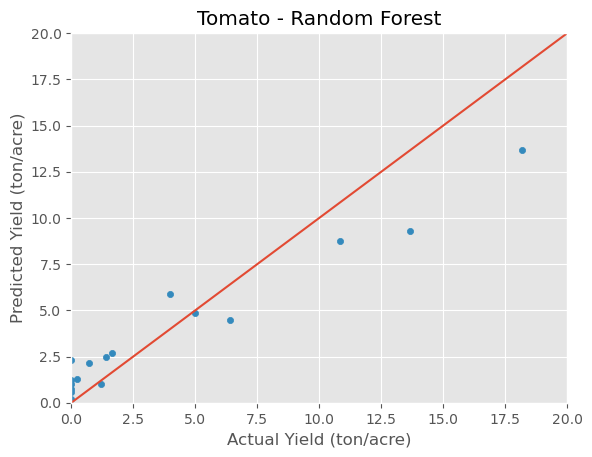

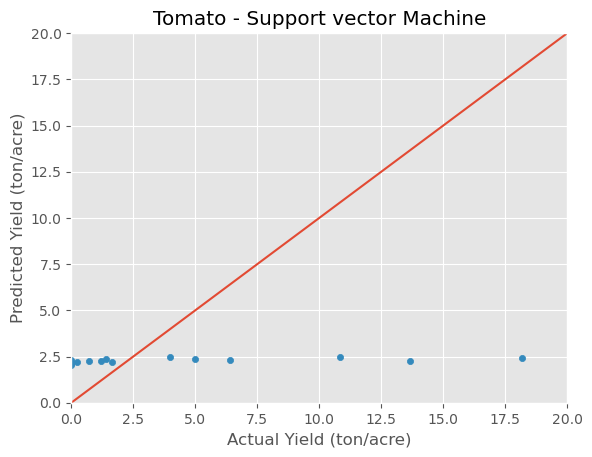

In [11]:
# model_list = [random_model,descion_model, svr]
# model_names = ['Random Forest', 'Decision Tree', 'Support vector Machine']

model_list = [random_model, svr]
model_names = ['Random Forest', 'Support vector Machine']
st =[ ]
for ind, model in enumerate(model_list):
    
    model = None
    model = model_list[ind]
    X = test.iloc[:,1:-1].values
    y = test.iloc[:,-1].values
#     scaler = StandardScaler()
#     scaler.fit(X)
#     X = scaler.fit_transform(X)
    model.fit(X,y)
    
    test['pred'] = [model.predict(X[x].reshape(1,-1))[0] for x in range(len(test))]
    
    mae, mse, var, corr, bias, r2, rpd = error(test, 'actual_yield', 'pred')
    
 
    dd = {'Model':model_names[ind],'Mean absolute error':mae, 'Mean squared error':mse,'Variance':var, 
          'Correlation':corr, 'Bias':bias, 'Coefficient of determination R^2':r2}
    st.append(dd)
    test.plot.scatter('actual_yield', 'pred')
    plt.xlim([0,20])
    plt.ylim([0,20])
    plt.xlabel('Actual Yield (ton/acre)')
    plt.ylabel('Predicted Yield (ton/acre)')
    plt.axline((0, 0), slope=1)
    plt.title(f'{crop} - {model_names[ind]}')

    
pd.DataFrame(st).round(2)

    

    

In [ ]:
X = test.iloc[:,1:-1].values
y = test.iloc[:,-1].values
scaler = StandardScaler()

scaler.fit(X)
X = scaler.fit_transform(X)

In [ ]:
x = 'actual_yield'
y = 'pred'

df = test

In [ ]:

for i in range(len(test)):
    test.at[i, 'pred'] = random_model.predict(X[i].reshape(1,-1))
    
    

In [ ]:
test1 = test.copy()
test1 = test1.rename(columns = {'actual_yield':'ytest'})
test1

In [ ]:
mae, mse, var, corr, bias, r2, rpd = error(test1)

In [ ]:
dd = {'Mean absolute error':mae, 'Mean squared error':mse,'Variance':var, 'Correlation':corr, 'Bias':bias, 
      'Coefficient of determination R^2':r2}

In [ ]:
st =[ ]
dd = {'Mean absolute error':mae,'Variance':var, 'Correlation':corr, 
      'Coefficient of determination R^2':r2}
st.append(dd)
pd.DataFrame(st).round(2)

In [ ]:
test1.plot.scatter('ytest', 'pred')
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Actual Yield (ton/acre)')
plt.ylabel('Predicted Yield (ton/acre)')
plt.axline((0, 0), slope=1)


In [ ]:
test1['fid']  = test1['fid'].astype('int')
test1 = test1.merge(client[['fid','Name']], on = 'fid')
test1.columns

In [ ]:
test1[['fid', 'Name', 'ytest', 'pred']].to_csv(f'../../output/results/{crop}.csv', index = False)

In [ ]:
# with open(f'../../model/{crop}.pkl', 'wb') as f:
#     pickle.dump(random_model, f)